In [2]:
from functools import partial

import torch.distributions
from transformer_lens import HookedTransformer
from IPython.display import SVG

import core
from utils import sankey_diagram_of_connectome

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model = HookedTransformer.from_pretrained("gpt2-small")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [56]:
model = HookedTransformer.from_pretrained("attn-only-4l")

Loaded pretrained model attn-only-4l into HookedTransformer


Exploring: 0 connexions [00:00, ? connexions/s]

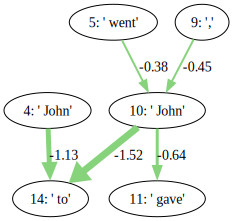

In [13]:
threshold = 0.3
prompt = "When Mary and John went to the store, John gave a book to"
corrupt_prompt = "When Tom and Sarah went to the store, Felix gave a book to"
c = core.connectom(model, prompt,
                   core.logit_diff_metric(model, ' Mary', ' John'),
                   # d.ZeroPattern(),
                   # core.CorruptIntervention(model, prompt, corrupt_prompt),
                   core.CropIntervention(model, prompt),
                   core.BasicStrategy(),
                   # d.BacktrackBisectStrategy(threshold),
                   # d.BacktrackingStrategy(threshold),
                   # strategy=d.BisectStrategy(threshold),
                   )
core.plot_attn_connectome(model, prompt, c).show()
graph = core.plot_graphviz_connectome(model, prompt, c, threshold=threshold).pipe('svg').decode('utf-8')
SVG(graph)


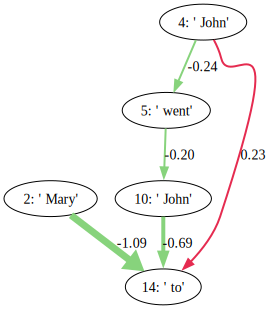

In [69]:
graph = core.plot_graphviz_connectome(model, prompt, c, threshold=0.2).pipe('svg').decode('utf-8')
SVG(graph)

Exploring: 0 connexions [00:00, ? connexions/s]

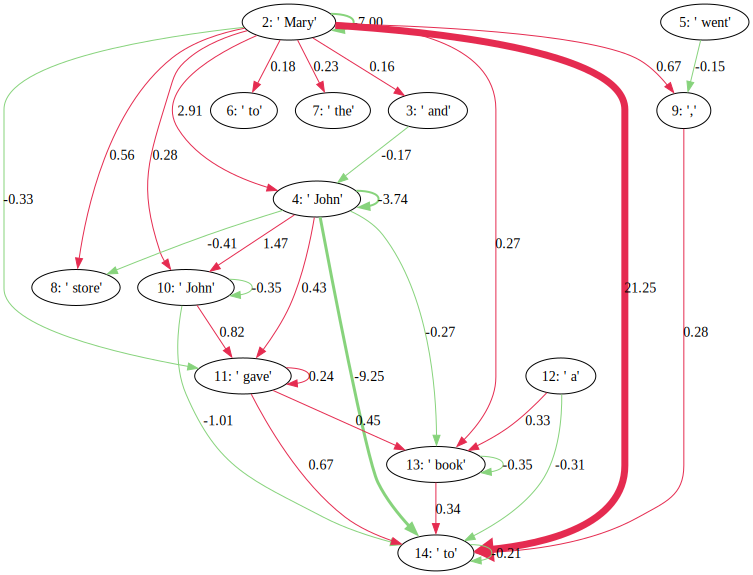

In [46]:
threshold = 0.15
prompt = '''def port(self, load, size, file, last):
"""oil column piece

    :param load: crime population
    :param size: unit dark
    :param'''
corrupt_prompt = prompt.replace("load", "banana").replace("size", "apple").replace("file", "pear").replace("last", "orange")

c = core.connectom(model, prompt,
                   core.logit_diff_metric(model, ' Mary', ' John'),
                   # d.logit_diffs_metric(model, ' file', [' self', ' load', ' size', ' last']),
                   # d.ZeroPattern(),
                   core.CorruptIntervention(model, prompt, corrupt_prompt),

                   core.BasicStrategy(),
                   # d.BacktrackBisectStrategy(threshold),
                   # d.BacktrackingStrategy(threshold),
                   # strategy=d.BisectStrategy(threshold),
                   )
# sankey_diagram_of_connectome(model, prompt, c, threshold=threshold);
core.plot_attn_connectome(model, prompt, c).show()
graph = core.plot_graphviz_connectome(model, prompt, c, threshold=threshold).pipe('svg').decode('utf-8')
SVG(graph)

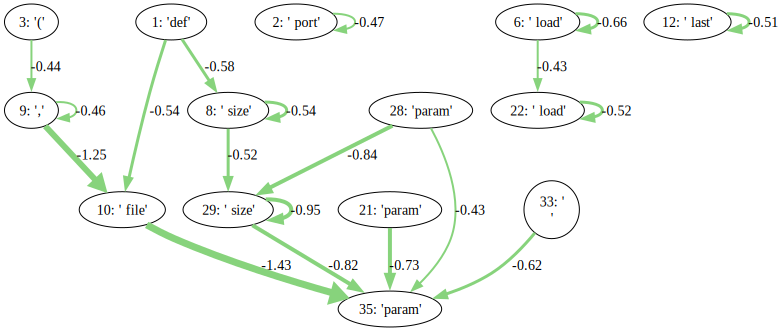

In [42]:
graph = core.plot_graphviz_connectome(model, prompt, c, threshold=0.4).pipe('svg').decode('utf-8')
SVG(graph)


  0%|          | 0/105 [00:00<?, ?it/s]

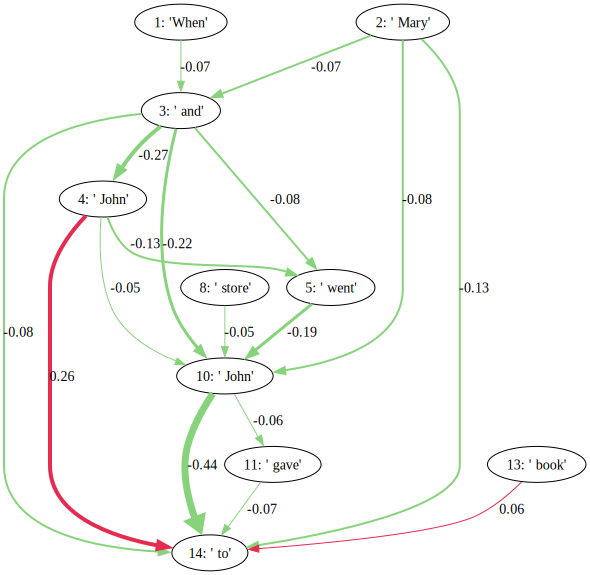

In [42]:
torch.topk()
dampening = 0.25
c = core.connectom(model, prompt,
                   core.logit_diff_metric(model, ' Mary', ' John'),
                   # d.CorruptIntervention(model, prompt, corrupt_prompt),
                   core.DampenIntervention(dampening),
                   # d.ZeroPattern(),
                   core.BasicStrategy(),
                   )
core.plot_attn_connectome(model, prompt, c).show()
graph = core.plot_graphviz_connectome(model, prompt, c, threshold=0.05).pipe('svg').decode('utf-8')
SVG(graph)